In [ ]:
!pip install -q -U transformers bitsandbytes accelerate qwen-vl-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 149.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 67.0 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoModelForImageTextToText, AutoProcessor, BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "Qwen/Qwen3-VL-4B-Instruct"

# Load model and processor manually instead of using pipeline
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    trust_remote_code=True
)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

print("Model loaded!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.91G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

Model loaded!


In [ ]:
# Define the JSON structure and Prompt

# The specific fields requested
json_structure_definition = """
{
    "scratchpad": "string", # a place to reason about *ALL* features below. Ensure you answer and reason about all questions asked here. Be concise.
    "description": "string", description of the scene
    "baby_present": bool,          # True ONLY if the baby is VISIBLE in the crib. Do not mistake with loose blankets.
    "face_down": bool,             # True ONLY if the baby is on its stomach.
    "crying": bool,                # True if the baby is crying.
    "sleeping": bool,              # True if the baby is sleeping.
    "severity": int,          # 0-10 scale where 10 is extreme danger.
    "hazards": [str],         # List of other potential hazards detected (if any).
    "notify": bool            # True if parents should be alerted immediately. Only if the baby is in danger.
}
"""

# Define the message template for Qwen
baby_monitor_messages = [
    {
        "role": "system",
        "content": "You are an intelligent baby monitor agent. Analyze the image provided. Determine the presence of a baby, and the safety of the baby if one is present. Do NOT confuse the baby with loose blankets. If the baby is not present, all fields (excluding description) are 0, false, or empty."
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "image": None}, # Placeholder for the actual image
            {"type": "text", "text": f"Return your analysis ONLY as a valid JSON object matching this structure:\n{json_structure_definition} Do not include any text outside the JSON. ASSISTANT:"}
        ]
    }
]

print("Prompt and JSON structure defined.")

Prompt and JSON structure defined.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Test Model on Random Sample**

Found annotation file: /content/drive/MyDrive/large/large.json
Found images directory: /content/drive/MyDrive/large/images
Selected images for testing: ['synth_00210.png', 'synth_00284.png', 'synth_00431.png', 'synth_00441.png', 'synth_00173.png']


==================== Processing: synth_00210.png ====================


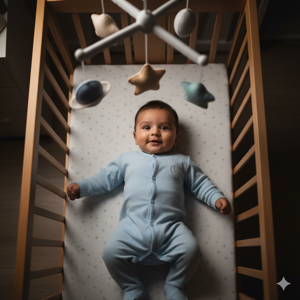


[Ground Truth Annotation]:
{
  "id": "synth_00210",
  "image": "images/synth_00210.png",
  "prompt": "overhead crib view of a gentle smile South Asian 9-month-old baby pajamas in a wooden crib, awake but content, nighttime with nightlight, mobile hanging above.",
  "label": "awake/peaceful",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nClassify the baby's state in the crib: asleep, awake/peaceful, awake/crying, or not-present."
    },
    {
      "from": "gpt",
      "value": "awake/peaceful"
    }
  ]
}

[Model Prediction]:
{
    "scratchpad": "A baby is visible in a crib, lying on its back, smiling. The crib has a mobile above with hanging toys. The baby is not on its stomach, not crying, and not sleeping. No hazards are present.",
    "description": "A smiling baby in a light blue onesie lies on its back in a wooden crib with a mobile above. The baby is awake and alert, not crying or sleeping.",
    "baby_present": true,
    "face_down": false,
    "cr

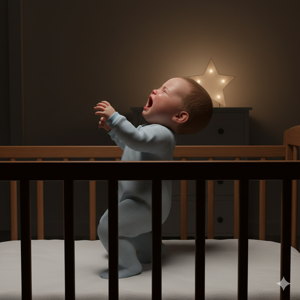


[Ground Truth Annotation]:
{
  "id": "synth_00284",
  "image": "images/synth_00284.png",
  "prompt": "side profile in crib of a mouth open wailing Caucasian 9-month-old baby in a onesie in a wooden crib, distressed, nighttime with nightlight, plain white crib sheets.",
  "label": "awake/crying",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nClassify the baby's state in the crib: asleep, awake/peaceful, awake/crying, or not-present."
    },
    {
      "from": "gpt",
      "value": "awake/crying"
    }
  ]
}

[Model Prediction]:
{
    "scratchpad": "A baby is visible in the crib, standing and crying. The baby is not on its stomach, and the scene is safe as the baby is in a crib with no loose blankets or other hazards. The baby is in distress but not in immediate danger.",
    "description": "A baby in a crib, standing and crying with arms raised, in a dimly lit room with a star-shaped light fixture in the background.",
    "baby_present": true,
    "face_do

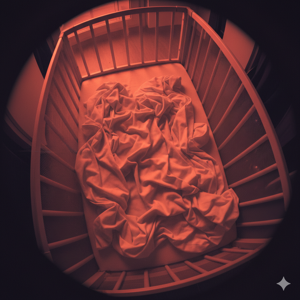


[Ground Truth Annotation]:
{
  "id": "synth_00431",
  "image": "images/synth_00431.png",
  "prompt": "slightly distorted fisheye lens of an empty playpen, rumpled plain white crib sheets, infrared-like glow, no baby visible.",
  "label": "not-present",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nClassify the baby's state in the crib: asleep, awake/peaceful, awake/crying, or not-present."
    },
    {
      "from": "gpt",
      "value": "not-present"
    }
  ]
}

[Model Prediction]:
{
    "scratchpad": "The image shows an empty crib with a crumpled blanket. There is no visible baby. The scene is devoid of any movement or signs of distress. No hazards are present.",
    "description": "An empty crib with a crumpled blanket, viewed through a fisheye lens with a red tint.",
    "baby_present": false,
    "face_down": false,
    "crying": false,
    "sleeping": false,
    "severity": 0,
    "hazards": [],
    "notify": false
}

==================== Processing

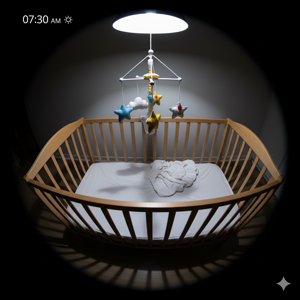


[Ground Truth Annotation]:
{
  "id": "synth_00441",
  "image": "images/synth_00441.png",
  "prompt": "angled from baby monitor camera of an empty wooden crib, rumpled mobile hanging above, bright overhead lamp, no baby visible.",
  "label": "not-present",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nClassify the baby's state in the crib: asleep, awake/peaceful, awake/crying, or not-present."
    },
    {
      "from": "gpt",
      "value": "not-present"
    }
  ]
}

[Model Prediction]:
{
    "scratchpad": "No baby is visible in the crib. The crib contains a mattress and a blanket, but no infant. The mobile is hanging above the crib. The scene is safe as no baby is present.",
    "description": "An empty crib with a mobile hanging above it, illuminated by a light. The crib has a mattress and a blanket, but no baby is visible.",
    "baby_present": false,
    "face_down": false,
    "crying": false,
    "sleeping": false,
    "severity": 0,
    "hazards": [

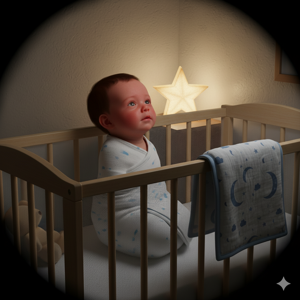


[Ground Truth Annotation]:
{
  "id": "synth_00173",
  "image": "images/synth_00173.png",
  "prompt": "slightly distorted fisheye lens of a curious gaze at ceiling Caucasian 3-month-old baby in a onesie in a wooden crib, awake but content, nighttime with nightlight, with patterned blanket.",
  "label": "awake/peaceful",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nClassify the baby's state in the crib: asleep, awake/peaceful, awake/crying, or not-present."
    },
    {
      "from": "gpt",
      "value": "awake/peaceful"
    }
  ]
}

[Model Prediction]:
{
    "scratchpad": "A baby is visible in the crib, sitting up and looking around. The baby is not on its stomach, not crying, and not sleeping. The crib has a star-shaped light and a blanket with moon patterns. No hazards detected.",
    "description": "A baby sitting up in a crib, looking around, with a star-shaped light and a moon-patterned blanket nearby.",
    "baby_present": true,
    "face_down": fal

In [ ]:
import os
import json
import random
from PIL import Image
from transformers import AutoProcessor
from qwen_vl_utils import process_vision_info  # Ensure this is imported

# Define path to the dataset
base_path = '/content/drive/MyDrive/large'

# find the JSON annotation file
all_files = os.listdir(base_path)
json_files = [f for f in all_files if f.endswith('large.json')]

if not json_files:
    print(f"No JSON annotation file found in {base_path}")
    annotations = []
else:
    annotation_file = os.path.join(base_path, json_files[0])
    print(f"Found annotation file: {annotation_file}")
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)

# find image files (check 'images' subdirectory first)
images_dir = os.path.join(base_path, 'images')
if 'images' in all_files and os.path.isdir(images_dir):
    print(f"Found images directory: {images_dir}")
    image_base = images_dir
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
else:
    print(f"Looking for images in base path: {base_path}")
    image_base = base_path
    image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# select a few random samples
num_samples = 5
if len(image_files) < num_samples:
    selected_images = image_files
else:
    selected_images = random.sample(image_files, num_samples)

print(f"Selected images for testing: {selected_images}\n")

# run inference and compare
for img_name in selected_images:
    img_path = os.path.join(image_base, img_name)
    image = Image.open(img_path).convert("RGB")

    print(f"\n{'='*20} Processing: {img_name} {'='*20}")
    display(image.resize((300, int(300 * image.height / image.width)))) # Display resized image

    # Attempt to retrieve annotation
    ann_entry = "No annotation found"

    # normalize paths for matching
    def match_annotation(img_filename, annotations):
        if isinstance(annotations, dict) and img_filename in annotations:
            return annotations[img_filename]
        elif isinstance(annotations, list):
            for item in annotations:
                if item.get('file_name') == img_filename or item.get('image') == img_filename:
                    return item
                if item.get('image') and item.get('image').endswith(img_filename):
                    return item
        return "No annotation found"

    ann_entry = match_annotation(img_name, annotations)

    print(f"\n[Ground Truth Annotation]:\n{json.dumps(ann_entry, indent=2)}")

    #Check model and processor
    if 'model' in globals() and 'processor' in globals():
      try:
          # Create a copy of the message template and insert the current image
          messages = [m.copy() for m in baby_monitor_messages]
          # Deep copy the content list to avoid modifying the template
          messages[1]["content"] = [c.copy() for c in baby_monitor_messages[1]["content"]]
          messages[1]["content"][0]["image"] = image

          # Prepare inputs
          text_prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
          image_inputs, video_inputs = process_vision_info(messages)

          inputs = processor(
              text=[text_prompt],
              images=image_inputs,
              videos=video_inputs,
              padding=True,
              return_tensors="pt",
          )

          # Move inputs to the correct device and generate
          inputs = {k: v.to(model.device) for k, v in inputs.items()}
          output_ids = model.generate(**inputs, max_new_tokens=256)

          generated_ids = [output_ids[len(inputs['input_ids'][0]):] for input_ids, output_ids in zip(inputs['input_ids'], output_ids)]
          response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

          print(f"\n[Model Prediction]:\n{response}")

      except Exception as e:
            print(f"\n[Model Prediction Error]: {e}")

    else:
        print("\n[Model Prediction]: Skipped (Model or processor not loaded. Please run the setup cells.)")

**Setup Save File**

In [ ]:
# Define output path for predictions
output_json_path = '/content/drive/MyDrive/large/model_predictions.json'

# Initialize list to store results
model_predictions = []

# Verify image_files availability (defined in previous cells)
if 'image_files' in globals():
    print(f"Total images to process: {len(image_files)}")
else:
    print("Warning: 'image_files' variable not found. Please ensure the previous data loading cell was executed.")

print(f"Results will be saved to: {output_json_path}")

Total images to process: 480
Results will be saved to: /content/drive/MyDrive/large/model_predictions.json


**Run Prediction Loop With Incremental Saving**



In [ ]:
import json
import re
from PIL import Image
import torch
import os
from qwen_vl_utils import process_vision_info

# extract and validate JSON from text
def extract_json(text):
    try:
        # Find the first valid JSON object
        match = re.search(r'(\{.*\})', text, re.DOTALL)
        if match:
            json_str = match.group(1)
            json_str = json_str.replace(r"\_", "_")
            return json.loads(json_str)
        return None
    except json.JSONDecodeError:
        return None

# Ensure we have the list of images
if 'image_files' not in globals():
    print("Error: image_files list is missing. Please run the previous cells.")
else:
    total_images = len(image_files)
    print(f"Starting robust inference on {total_images} images with retries...\n")

    # Define output path if not already defined
    if 'output_json_path' not in globals():
         output_json_path = os.path.join(base_path, 'model_predictions.json')

    # Ensure the results list exists
    if 'model_predictions' not in globals():
        model_predictions = []

    # Loop through all images
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(image_base, img_name)

        # Retry settings
        max_retries = 3

        final_prediction = None
        raw_response = ""
        valid_json = False

        try:
            # Open and convert image
            image = Image.open(img_path).convert("RGB")

            # Retry loop
            for attempt in range(max_retries + 1):

                #Qwen input prep
                # Create a copy of the message template
                messages = [m.copy() for m in baby_monitor_messages]
                # Copy the content list to avoid modifying the template
                messages[1]["content"] = [c.copy() for c in baby_monitor_messages[1]["content"]]
                # Insert the current image
                messages[1]["content"][0]["image"] = image

                # Prepare inputs using processor and qwen_vl_utils
                text_prompt = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
                image_inputs, video_inputs = process_vision_info(messages)

                inputs = processor(
                    text=[text_prompt],
                    images=image_inputs,
                    videos=video_inputs,
                    padding=True,
                    return_tensors="pt"
                )

                # Move inputs to the correct device (using 'model' instead of 'pipe')
                inputs = {k: v.to(model.device) for k, v in inputs.items()}

                # Generate output
                output_ids = model.generate(
                    **inputs,
                    max_new_tokens=512,
                    repetition_penalty=1.1,
                    temperature=0.1,
                )

                # Decode the output, slice off qwen input tokens
                generated_ids = [output_ids[len(inputs['input_ids'][0]):] for input_ids, output_ids in zip(inputs['input_ids'], output_ids)]
                response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

                raw_response = response

                # Attempt to parse JSON
                parsed_data = extract_json(response)
                if parsed_data:
                    final_prediction = parsed_data
                    valid_json = True
                    break
                else:
                    print(f"  - Attempt {attempt + 1} failed for {img_name}.")
                    print(f"    >> Failed Output: {response}")
                    if attempt < max_retries:
                        print("    Retrying...")

            # Create result entry
            result_entry = {
                "filename": img_name,
                "prediction": final_prediction if final_prediction else raw_response,
                "valid_json": valid_json
            }

            # Append to global list
            model_predictions.append(result_entry)

            # Incremental save to JSON file
            with open(output_json_path, 'w') as f:
                json.dump(model_predictions, f, indent=2)

            status = "Valid JSON" if valid_json else "Failed Parsing"
            print(f"Processing {i+1}/{total_images}: {img_name} - {status}")

        except Exception as e:
            print(f"Error processing {img_name}: {e}")

    print("\nRobust inference process finished.")

Starting robust inference on 480 images with retries...

Processing 1/480: synth_00030.png - Valid JSON
Processing 2/480: synth_00009.png - Valid JSON
Processing 3/480: synth_00029.png - Valid JSON
Processing 4/480: synth_00025.png - Valid JSON
Processing 5/480: synth_00018.png - Valid JSON
Processing 6/480: synth_00026.png - Valid JSON
Processing 7/480: synth_00038.png - Valid JSON
Processing 8/480: synth_00033.png - Valid JSON
Processing 9/480: synth_00013.png - Valid JSON
Processing 10/480: synth_00015.png - Valid JSON
Processing 11/480: synth_00019.png - Valid JSON
Processing 12/480: synth_00037.png - Valid JSON
Processing 13/480: synth_00021.png - Valid JSON
Processing 14/480: synth_00005.png - Valid JSON
Processing 15/480: synth_00042.png - Valid JSON
Processing 16/480: synth_00014.png - Valid JSON
Processing 17/480: synth_00010.png - Valid JSON
Processing 18/480: synth_00031.png - Valid JSON
Processing 19/480: synth_00023.png - Valid JSON
Processing 20/480: synth_00039.png - Val